<a href="https://colab.research.google.com/github/austinbennysmith/OSOM-ERDDAP/blob/master/MODIS_%26_VIIRS_Anomalies_Slow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook graphs **anomalies from the monthly climatology** against time for chlorophyll a, k490, or PAR in the MODIS or VIIRS data. It will first graph the climatologies of the chosen variable separately, and then graphs the anomalies using the climatologies. This notebook only works with monthly composites.

In [ ]:
#First, some installations and imports:
!pip install netCDF4
import requests
from netCDF4 import Dataset as NetCDFFile
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import calendar
import datetime

The following code cell defines a function that makes a list of dates and uses conditionals to define some variables that will be used in making the url and labeling the plots. This is the cell where you can change the dates you want to graph.

In [3]:
#For a more thoroughly commented version of this cell, see the "MODIS & VIIRS Spatial Averages Slow" notebook
#the code dealing with datetime here is based on code at this link: https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
#This link also helped with datetime stuff: https://stackoverflow.com/questions/5734438/how-to-create-a-month-iteratorimport datetime
import datetime
from datetime import date, timedelta
from datetime import datetime as dt
def conditionals():
  #since this is a function, and I want a bunch of the variables to be referenced outside of the function, I use global below for a bunch of the variables. Otherwise if I try to reference those variables outside of this function, it won't work.
  global dates2
  global myvar
  global title
  global dataset_id
  global tt
  global tres
  global unit
  global means
  global timearray
  global satellite
  global thecolor
  global shortsat
  dates2 = []
  #Modis dataset IDs: 'erdMH1chla1day', 'erdMH1chla8day', 'erdMH1chlamday', 'erdMH1kd4901day', 'erdMH1kd4908day', 'erdMH1kd490mday', 'erdMH1par01day', 'erdMH1par08day', 'erdMH1par0mday'
  #VIIRS dataset IDs: 'erdVH2018chla8day', 'erdVH2018chla1day', 'erdVH2018chlamday', 'erdVH2018k4908day', 'erdVH2018k4901day', 'erdVH2018k490mday', 'erdVH2018par8day', 'erdVH2018par1day', 'erdVH2018parmday'
  dataset_id = input("What's the dataset ID?")
  if 'MH' in dataset_id:
    satellite = 'MODIS'
    shortsat = 'MODIS'
    thecolor = 'cyan'
  elif 'VH' in dataset_id:
    satellite = 'Suomi-NPP/VIIRS'
    shortsat = 'VIIRS'
    thecolor = 'magenta'
  tres = dataset_id[-4:]
  if tres=='8day' and 'MH' in dataset_id:
    tt = '8 Day '
    start_date = date(2003, 1, 5)
    end_date = date(2020, 5, 20)
    delta = timedelta(days = 8)
    while start_date<=end_date:
      dates2.append(str(start_date))
      start_date += delta
  elif tres=='8day' and 'VH' in dataset_id:
    tt = '8 Day '
    start_date = date(2012, 1, 5)
    end_date = date(2020, 5, 12)
    delta = timedelta(days = 8)
    while start_date<=end_date:
      dates2.append(str(start_date))
      start_date += delta
  elif tres=='1day' and 'MH' in dataset_id:
    tt = '1 Day '
    start_date = date(2003, 1, 1)
    end_date = date(2020, 6, 16)
    delta = timedelta(days = 1)
    while start_date<=end_date:
      dates2.append(str(start_date))
      start_date += delta
  elif tres=='1day' and 'VH' in dataset_id:
    tt = '1 Day '
    start_date = date(2012, 1, 2)
    end_date = date(2020, 6, 8)
    delta = timedelta(days = 1)
    while start_date<=end_date:
      dates2.append(str(start_date))
      start_date += delta
  elif tres=='mday' and 'MH' in dataset_id:
    tt = 'Monthly '
    start_date = date(2003, 1, 16)
    end_date = date(2020, 4, 16)
    def months_iter(start_month, start_year, end_month, end_year):
      start_date = datetime.date(start_year, start_month, 1)
      end_date = datetime.date(end_year, end_month, 1)
      date = start_date
      while date <= end_date:
          yield (date.month, date.year)
          new_new = str(datetime.date(date.year, date.month, 16))
          dates2.append(new_new)
          days_in_month = calendar.monthrange(date.year, date.month)[1]
          date += datetime.timedelta(days_in_month)
    def months(start_month, start_year, end_month, end_year):
      return tuple(d for d in months_iter(start_month, start_year, end_month, end_year))
    months(1, 2003, 4, 2020)
  elif tres=='mday' and 'VH' in dataset_id:
    tt = 'Monthly '
    start_date = date(2012, 1, 15)
    end_date = date(2020, 4, 15)
    def months_iter(start_month, start_year, end_month, end_year):
      start_date = datetime.date(start_year, start_month, 1)
      end_date = datetime.date(end_year, end_month, 1)
      date = start_date
      while date <= end_date:
          yield (date.month, date.year)
          new_new = str(datetime.date(date.year, date.month, 15))
          dates2.append(new_new)
          days_in_month = calendar.monthrange(date.year, date.month)[1]
          date += datetime.timedelta(days_in_month)
    def months(start_month, start_year, end_month, end_year):
      return tuple(d for d in months_iter(start_month, start_year, end_month, end_year))
    months(1, 2012, 4, 2020)
  if 'chla' in dataset_id and 'MH' in dataset_id:
    myvar = 'chlorophyll'
    unit = 'mg m^-3'
    title = 'Chlorophyll a '
  elif 'chla' in dataset_id and 'VH' in dataset_id:
    myvar = 'chla'
    unit = 'mg m^-3'
    title = 'Chlorophyll a'
  elif 'kd490' in dataset_id or 'k490' in dataset_id:
    myvar = 'k490'
    unit = 'm^-1'
    title = 'K490 '
  elif 'par' in dataset_id:
    myvar = 'par'
    unit = 'einstein m^-2 day ^-1'
    title = 'Photosynthetically Available Radiation '

Next, I define a function that loops through the list of dates and creates a list of means for each month, which will allow me to plot the climatologies. For a more thoroughly commented version of this code, see "MODIS & VIIRS Climatologies Slow"

In [4]:
def climatology():
  global finalmeans
  global metadates
  global metameans
  global months
  metadates = []
  metameans = []
  months = []
  for y in range(1,13):
    months.append(y)
  for k in range(1, 13):
    monthdates = []
    for i in dates2:
      datee = dt.strptime(i, "%Y-%m-%d")
      if datee.month == k:
        monthdates.append(i)
    metadates.append(monthdates)
  for j in metadates:
    means = []
    for x in metadates[metadates.index(j)]:
      url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+x+'T00:00:00Z):1:('+x+'T00:00:00Z)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
      r = requests.get(url, allow_redirects=True)
      open('test.nc', 'wb').write(r.content)
      nc = NetCDFFile('test.nc')
      nc
      mapvar = nc.variables[myvar][:]
      means.append(np.nanmean(mapvar))
    metameans.append(means)
  finalmeans = []
  for z in metameans:
    finalmeans.append(np.nanmean(metameans[metameans.index(z)]))
  plt.plot(months, finalmeans, color = 'magenta')
  plt.title('Monthly Climatology of '+title)
  plt.xlabel('Calendar Month')
  plt.ylabel(myvar+'('+unit+')')
  plt.show()

Next, I define a function that uses the monthly climatology to find the anomalies by month and put them in a list that can be used for graphing later.

In [5]:
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/Anomalies/MODIS Anomalies'
def anomaly():
  #since this is a function, and I want a bunch of the variables to be referenced outside of the function, I use global below for a bunch of the variables. Otherwise if I try to reference those variables outside of this function, it won't work.
  global anomalies
  global means
  global timearray
  #defining some empty lists that I'll use for graphing:
  anomalies = []
  means = []
  timearray = []
  for i in dates2: #looping through all the dates
    #Creating the url using previously defined variables and opening the dataset:
    url = 'https://pricaimcit.services.brown.edu/erddap/griddap/'+dataset_id+'.nc?'+myvar+'[('+i+'T00:00:00Z):1:('+i+'T00:00:00Z)][(41.5):1:(40.5)][(-72.65):1:(-70.25)]'
    r = requests.get(url, allow_redirects=True)
    open('test.nc', 'wb').write(r.content)
    nc = NetCDFFile('test.nc')
    nc
    lat = nc.variables['latitude'][:]
    lon = nc.variables['longitude'][:]
    time = nc.variables['time'][:]
    mapvar = nc.variables[myvar][:]
    index = datetime.datetime.strptime(i, '%Y-%m-%d').month #figuring out which month date i is in
    addition = np.mean(mapvar) - finalmeans[index-1] #subtracting finalmenas[index-1] from the spatial average of the chosen variable for date i yields the anomaly from climatology
    anomalies.append(addition) #appending the calculated anomaly to the anomalies list allows graphing later.
    timearray.append(dt.fromtimestamp(time))

Finally, I execute conditionals(), climatology(), and anomaly() each twice, and use the results to graph the climatology of the chosen variable for each satellite individually, as well as the anomalies from the climatology for both satellites together.

Note: the graph of anomalies shown here for chlorophyll a is identical to the one shown in "MODIS & VIIRS Faster Comparisons."

Also, be sure to input a MODIS dataset ID first, and a VIIRS ID second, so that the colors in the graph are correct.

What's the dataset ID?erdMH1chlamday


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater


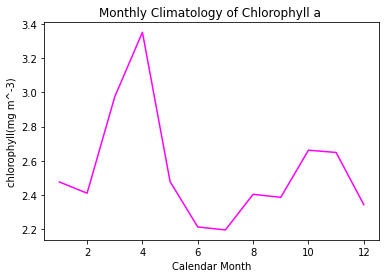

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


What's the dataset ID?erdVH2018chlamday


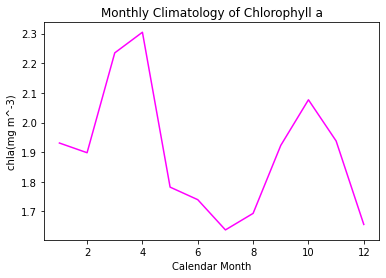

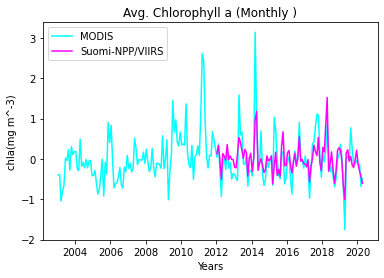

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#images_dir = '/content/gdrive/Shared drives/BFK_BOG/SURF_UG/Benny/Images/Phytoplankton_averages/Anomalies/Anomaly_Comparisons'
conditionals()
climatology()
anomaly()
#below, I set the variables anomalies2, timearray2, and satellite2, because once I run the two functions again the variables anomalies, timearray, and satellite will be given new values. So I need to store them in separate variables to use them later in plotting.
anomalies2 = anomalies
timearray2 = timearray
satellite2 = satellite
conditionals()
climatology()
anomaly()
anomalies3 = anomalies
timearray3 = timearray
satellite3 = satellite
fig, ax = plt.subplots()
ax.plot(timearray2, anomalies2, label = satellite2, color = 'cyan')
ax.plot(timearray3, anomalies3, label = satellite3, color = 'magenta')
plt.legend(loc="upper left")
plt.xlabel('Years')
plt.ylabel(myvar+'('+unit+')')
plt.title('Avg. '+title+' ('+tt+')')
#plt.savefig(f"{images_dir}/"+tt+myvar+".png")
plt.show()